In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from skbio.diversity import alpha_diversity, beta_diversity
from scipy.spatial.distance import cdist
# from skbio.stats.ordination import pcoa, pcoa_biplotb
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import scipy.io as sio
import scipy
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')
import importlib

In [2]:
import sys  
sys.path.insert(0, '../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic
import roc_ps
# importlib.reload(dimen_reduc)
# importlib.reload(meta_ord)
# importlib.reload(paga_res)
# importlib.reload(sliding_window)
# importlib.reload(statistic)

## Variables

In [3]:
top_path = "../data/"
    
file_name = top_path + 'all_df_26062023.xlsx'
sheet_abun = 'abundance'
sheet_meta = 'meta'

In [10]:
date = '02072023'
n_neighbors = 20
n_pcs = 50 #30

metric = 'euclidean'
use_rep = True
in_path = top_path + 'in_df_02072023.xlsx'
out_path = top_path + 'out_df_02072023.xlsx'

In [ ]:
# 0. Order data
# 1. Run paga
# 2. NN finding
# 3. Review results

## 0. Order data

#### Load data

In [5]:
df = pd.read_excel(in_path, sheet_name = sheet_abun, index_col = 0)
meta = pd.read_excel(in_path, sheet_name = sheet_meta, index_col = 0)
display(df.shape)
display(meta.shape)

(8026, 373)

(8026, 33)

#### Prepare df for PAGA

In [12]:
if metric == 'euclidean':
    center_df = dimen_reduc.get_center(df)
    pca_df, pca_loadings, pca_variance_ratio, pca_variance = dimen_reduc.get_pca_reg(center_df)
    print('pca results: ' + str(pca_df.shape))

elif metric == 'braycurtis':
    if not use_rep:   
        bc_dist_df = dimen_reduc.get_bc_dist(df)
        pcoa_df, pcoa_loadings, pcoa_variance_ratio, pcoa_variance = dimen_reduc.get_pcoa(bc_dist_df, df, 'index')
        print('pcoa results: ' + str(pca_df.shape))
    else:
        print('df dimensions: ', str(df.shape))

pca results: (8026, 50)


#### Create adata

In [13]:
meta['root'] = np.where((meta['BV_bin'] == 1) & (meta['shannon_index'] > 3.5), 'root', 'reg')#in_meta.apply(lambda row: get_label(row), axis = 1)
print(meta.groupby(['root'])['sampleID'].count())
print(meta[meta['root'] == 'root'].groupby('subCST')['sampleID'].count())

root
reg     8005
root      21
Name: sampleID, dtype: int64
subCST
III-B     1
IV-A      1
IV-B     17
IV-C0     2
Name: sampleID, dtype: int64


In [14]:
if metric == 'euclidean':
    adata = AnnData(X = df.to_numpy(),
                        obs = meta[['CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root']],
                        var = pd.DataFrame(index = df.columns),
                        uns = {'pca': {}})
    adata.obsm['X_pca'] = pca_df 
    adata.uns['pca']['variance_ratio'] = pca_variance_ratio 
    adata.uns['pca']['variance'] = pca_variance
    adata.varm['PCs'] = pca_loadings 
else:
    adata = AnnData(X = df.to_numpy(),
            obs = meta[['CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root']],
            var = pd.DataFrame(index = df.columns))
adata.X = adata.X.astype('float64')


## 1. Run PAGA

... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical
... storing 'root' as categorical


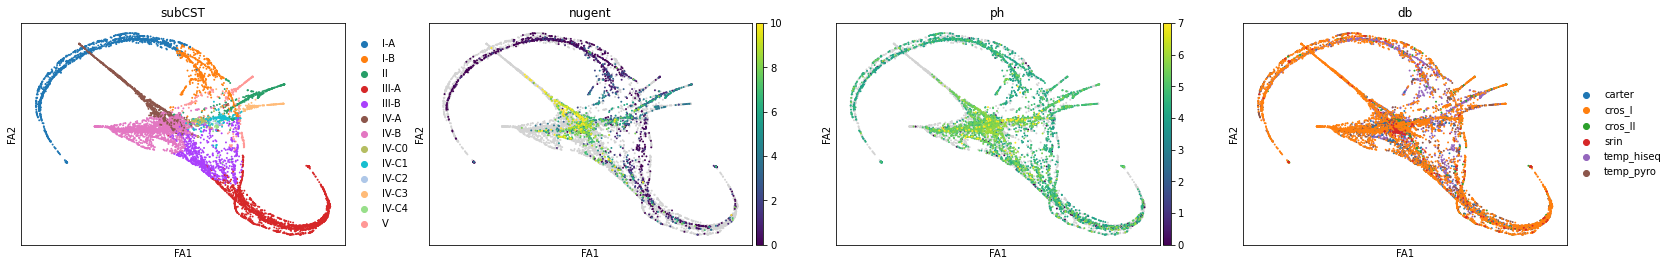

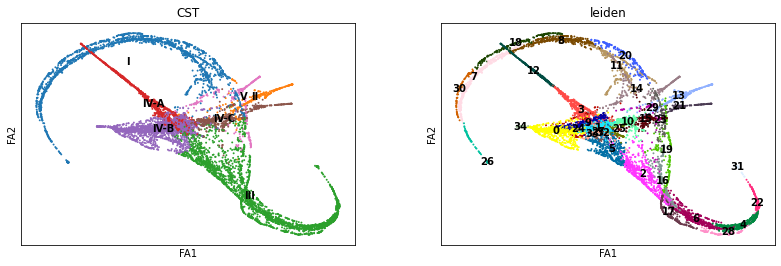

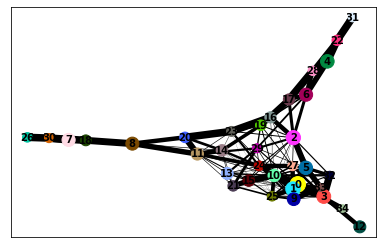

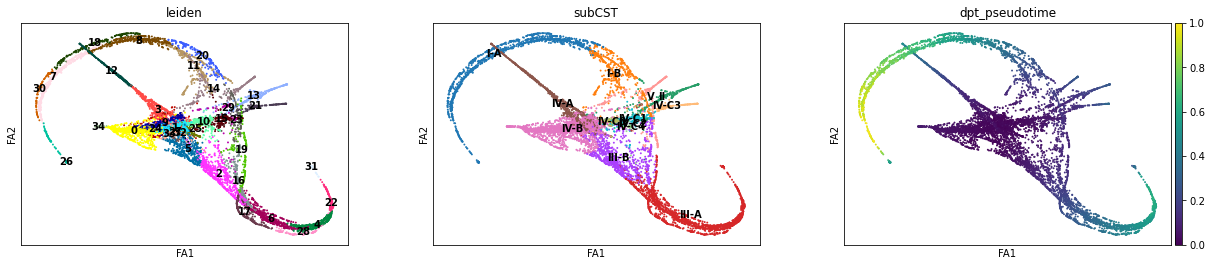

In [15]:
adata_res = paga_res.run_paga(adata, n_neighbors, n_pcs, 'root', 'root', metric)

#### Save results

In [17]:
dict_res = paga_res.paga_results(adata_res, df, meta, 'euclidean')
ps_path = top_path + 'ps_res_PCA_umap_' + str(date) + '.xlsx'
paga_res.save_excel(ps_path, dict_res)

In [ ]:
# umap_dict = {'connetivities': pd.DataFrame(adata.obsp['connectivities'].todense(), columns = in_meta.index, index = in_meta.index), 
#              'distances': pd.DataFrame(adata.obsp['distances'].todense(), columns = in_meta.index, index = in_meta.index)}
# umap_path = top_path + 'ps_res/' + '/umap_BC_X_' + str(date) + '.xlsx'
# paga_res.save_excel(umap_path, umap_dict)

## 2. Review results

In [18]:
res_meta = dict_res['meta']

In [19]:
# graph_df['vag_fluid'] = graph_df.vag_fluid.astype(str)
graph_df = pd.DataFrame(adata_res.obsm['X_draw_graph_fa'], index = res_meta.index, columns=['fa1', 'fa2'])
graph_df = graph_df.merge(res_meta, left_index=True, right_index=True)
graph_df['BV_status'] = graph_df['BV_status'].fillna('no_data')
px.scatter(graph_df, x = 'fa1', y = 'fa2', color = 'root', width = 500, height = 430)

<AxesSubplot:>

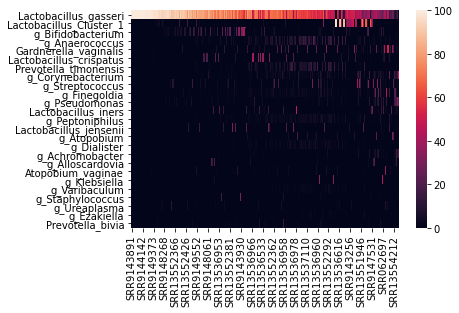

In [20]:
cst = 'II'
arm_meta = res_meta.loc[res_meta['CST'] == cst].sort_values('mt_pseudotime')
arm_df = df.loc[arm_meta.index]
s = arm_df.sum()
arm_df = arm_df[s.sort_values(ascending = False).index]
arm_plot_df = arm_df.iloc[:, :25].T
sns.heatmap(arm_plot_df, yticklabels = True)

### 3. NN finding

In [21]:
out_df = pd.read_excel(out_path, sheet_name = sheet_abun, index_col = 0)
out_meta = pd.read_excel(out_path, sheet_name = sheet_meta, index_col = 0)
display(out_df.shape)
display(out_meta.shape)

(515, 373)

(515, 32)

In [22]:
out_df = out_df[df.columns]

In [23]:
def get_projected_pca(df, loadings):
    arr = np.array(df)
    pca_projected = np.matmul(arr, loadings)
    pca_projected_df = pd.DataFrame(pca_projected, index = df.index, columns = ['PCA' + str(num) for num in range(1, pca_projected.shape[1] + 1)])
    
    return pca_projected_df

def get_nn(pca_projected_df, pca_df, metric = 'braycurtis'):
    dist = cdist(pca_projected_df, pca_df, metric = metric)
    min_dist_arr = pd.DataFrame(dist, columns = graph_df.index).idxmin(axis = 1)
    min_dist_df = min_dist_arr.to_frame(name = 'closest_sample')
    min_dist_df.index = pca_projected_df.index
    
    return min_dist_df

def get_meta_with_nn(min_dist_df, graph_df, out_meta):
    out_meta = out_meta.join(min_dist_df)
    graph_df.rename(columns = {'CST': 'closest_sample_CST'}, inplace = True)
    out_meta = out_meta.merge(graph_df[['closest_sample_CST', 'mt_pseudotime', 'fa1', 'fa2']], left_on = 'closest_sample', right_index = True)
    
    return out_meta

def all_func(out_df, pca_loadings, in_pca_df, in_meta, out_meta, metric = 'braycurtis'):
    if metric != 'braycurtis':
        pca_projected_df = get_projected_pca(out_df, pca_loadings)
        min_dist_df = get_nn(pca_projected_df, in_pca_df)
    else:
        min_dist_df = get_nn(out_df, in_pca_df)
    
    final_out_meta = get_meta_with_nn(min_dist_df, in_meta, out_meta)
    
    return final_out_meta

In [24]:
final_out_meta = all_func(out_df, out_df, df, graph_df, out_meta, metric = 'braycurtis')

In [26]:
dict_nn = {'meta': final_out_meta, 'abundance': out_df}
nn_path = top_path + 'nn_res_PCA_umap_02072023.xlsx'
paga_res.save_excel(nn_path, dict_nn)